In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import scipy
import numpy as np

(가정) 유기첨가제 brightner(광택제)는 실제 장비의 구동 시간과 선형 관계에 있을것이다.
- 데이터는 간헐적 데이터가 아닌 연속된 데이터로 가정
- 데이터는 1일 1회 첨가제를 주입

Min : 1.6
Max : 2.9
Mean : 2.1878048780487807


<Figure size 640x480 with 0 Axes>

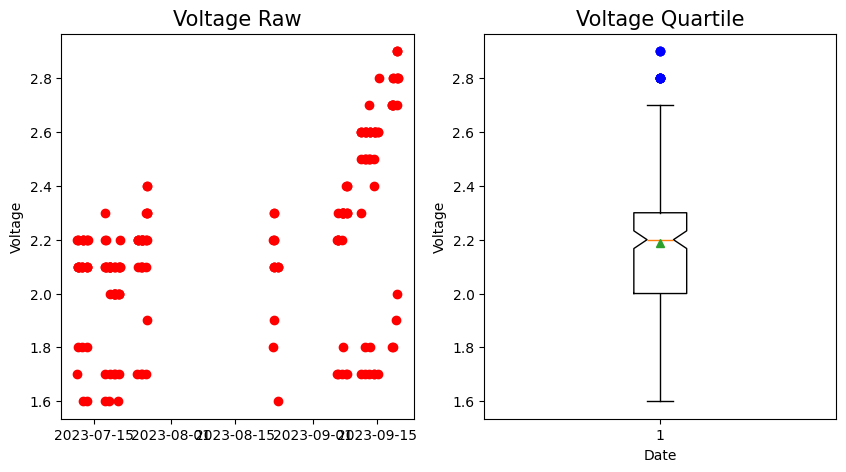

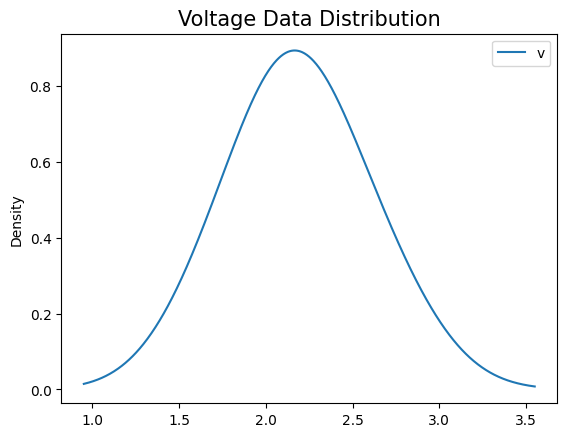

<Figure size 640x480 with 0 Axes>

In [2]:
# raw 데이터 읽기
csv_raw = pd.read_csv("./data/data.csv", skiprows=1, parse_dates=['datetime'], dayfirst=False)

# 전압 데이터 분포 확인 
data_v = csv_raw[['datetime', 'v']].dropna().sort_values("datetime")
data_v = data_v.set_index('datetime').sort_index()

print(f"Min : {data_v['v'].min()}")
print(f"Max : {data_v['v'].max()}")
print(f"Mean : {data_v['v'].mean()}")

# draw
plt.clf()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(data_v, 'ro')
plt.ylabel('Voltage')
plt.title('Voltage Raw', fontsize=15)

plt.subplot(1,2,2)
plt.boxplot(data_v, sym="bo", notch=True, showmeans=True)
plt.xlabel('Date')
plt.ylabel('Voltage')
plt.title('Voltage Quartile', fontsize=15)

data_v.plot.kde(bw_method=1)
plt.title('Voltage Data Distribution', fontsize=15)
plt.show()

plt.tight_layout()
plt.show()


Min : 0.05
Max : 95.0
Mean : 50.5029756097561


<Figure size 640x480 with 0 Axes>

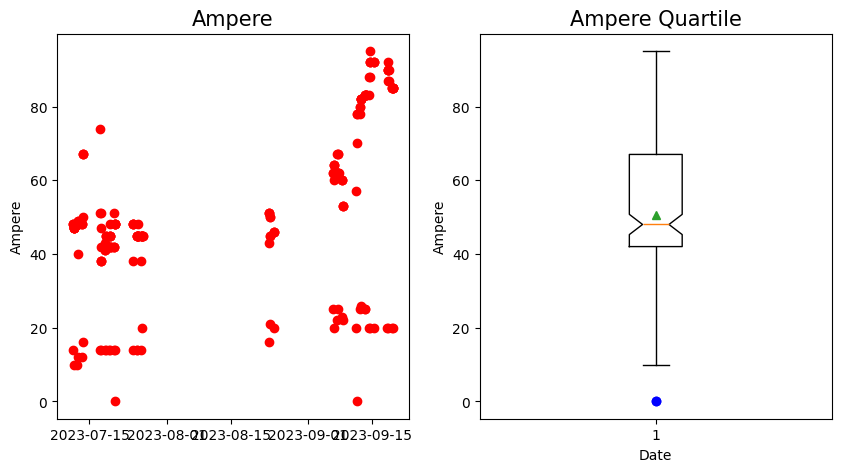

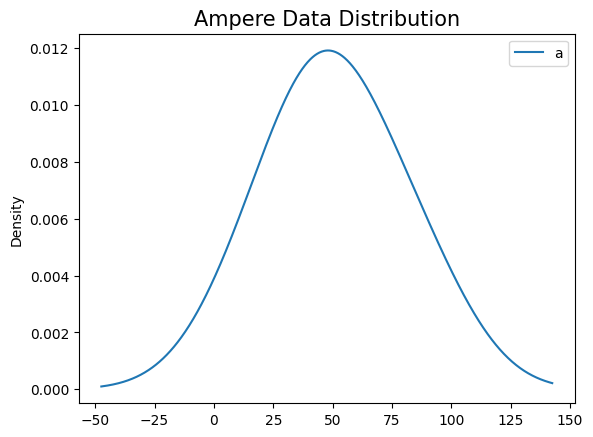

<Figure size 640x480 with 0 Axes>

In [3]:
data_a = csv_raw[['datetime', 'a']].dropna().sort_values("datetime")
data_a = data_a.set_index('datetime').sort_index()

print(f"Min : {data_a['a'].min()}")
print(f"Max : {data_a['a'].max()}")
print(f"Mean : {data_a['a'].mean()}")

# draw
plt.clf()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(data_a, 'ro')
plt.ylabel('Ampere')
plt.title('Ampere', fontsize=15)

plt.subplot(1,2,2)
plt.boxplot(data_a, sym="bo", notch=True, showmeans=True)
plt.xlabel('Date')
plt.ylabel('Ampere')
plt.title('Ampere Quartile', fontsize=15)

data_a.plot.kde(bw_method=1)
plt.title('Ampere Data Distribution', fontsize=15)
plt.show()

plt.tight_layout()
plt.show()

Min : 0.0
Max : 450.0
Mean : 240.6


<Figure size 640x480 with 0 Axes>

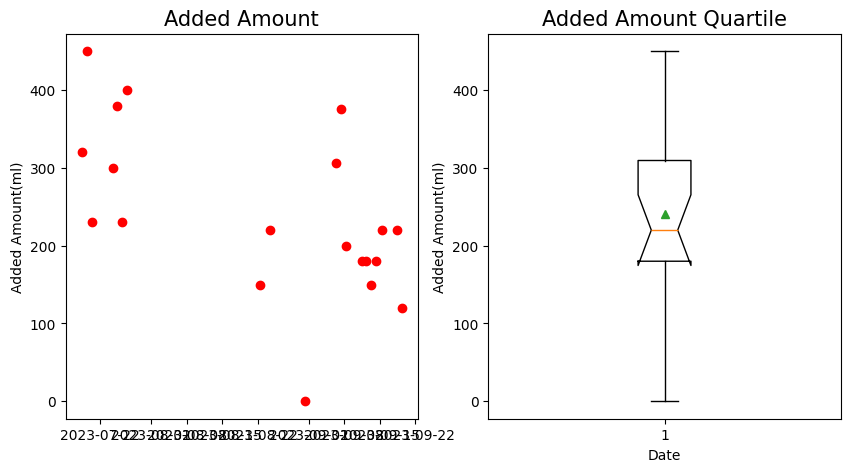

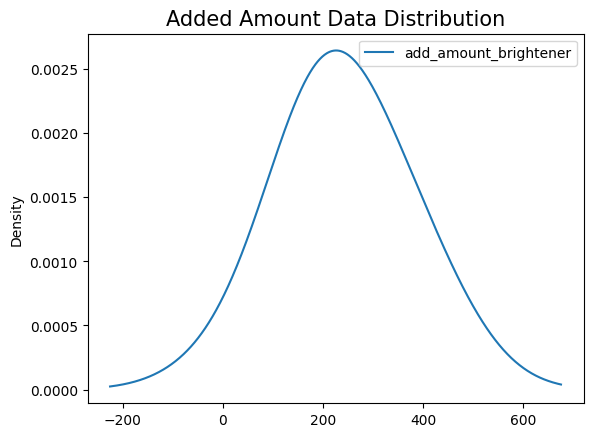

<Figure size 640x480 with 0 Axes>

In [4]:
# Brightener 유기첨가제 주입양 분포
data_brightener = csv_raw[['datetime', 'add_amount_brightener']].dropna().sort_values("datetime")
data_brightener = data_brightener.set_index('datetime').sort_index()

print(f"Min : {data_brightener['add_amount_brightener'].min()}")
print(f"Max : {data_brightener['add_amount_brightener'].max()}")
print(f"Mean : {data_brightener['add_amount_brightener'].mean()}")

# draw
plt.clf()
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(data_brightener, 'ro')
plt.ylabel('Added Amount(ml)')
plt.title('Added Amount', fontsize=15)

plt.subplot(1,2,2)
plt.boxplot(data_brightener, sym="bo", notch=True, showmeans=True)
plt.xlabel('Date')
plt.ylabel('Added Amount(ml)')
plt.title('Added Amount Quartile', fontsize=15)

data_brightener.plot.kde(bw_method=1)
plt.title('Added Amount Data Distribution', fontsize=15)
plt.show()

plt.tight_layout()
plt.show()

In [89]:
# 

# 날짜별 장비 구동 시간 추출
data_dt = csv_raw[['datetime', 'warmup', 'off', 'add_amount_brightener', 'add_amount_carrier']].sort_values("datetime")

# warmup datetime list
data_dt_warmup = data_dt[~data_dt["warmup"].isnull()]

# off datetime list
data_dt_off = data_dt[~data_dt["off"].isna()]

# brightener
data_dt_brightener = (data_dt[~data_dt["add_amount_brightener"].isna()])[["datetime", "add_amount_brightener"]]
#print(data_dt_brightener.head())

data_dt_carrier = (data_dt[~data_dt["add_amount_brightener"].isna()])[["datetime", "add_amount_carrier"]]
#print(data_dt_carrier.head())


data_dt_wt = pd.DataFrame(dtype=float, columns=['datetime', 'wt', 'add_amount_brightener', 'add_amount_carrier'])

# working time calc between warmup and off
for warmup, off in zip(data_dt_warmup.iterrows(), data_dt_off.iterrows()):
    warmup_t = warmup[1]["datetime"]
    off_t = off[1]["datetime"]
    dt = off_t - warmup_t
    
    data_dt_wt.loc[len(data_dt_wt.index)] = [off_t, dt, np.nan, np.nan]

data_dt_wt = data_dt_wt.groupby(pd.Grouper(key='datetime', freq='D', sort=True)).sum()
data_dt_wt = data_dt_wt[data_dt_wt["wt"]!=datetime.timedelta(seconds=0)]

for idx, wt in enumerate(data_dt_wt.iterrows()):
    mask = (data_dt_brightener["datetime"]>wt[0]) & (data_dt_brightener["datetime"]<=wt[0]+datetime.timedelta(hours=24))
    if not data_dt_brightener.loc[mask].empty:
        # wt[1]["add_amount_brightener"] = data_dt_brightener.loc[mask]["add_amount_brightener"].values[0]
        print(data_dt_wt[0])
        data_dt_wt.iloc[[idx]]["add_amount_brightener"] = data_dt_brightener.loc[mask]["add_amount_brightener"].values
        #print(idx, data_dt_wt[idx])
        #print(wt[1]["add_amount_brightener"])
        #print(wt[1]["add_amount_brightener"])
        #print(data_dt_brightener.loc[mask]["add_amount_brightener"].values[0])

print(data_dt_wt)
    



KeyError: 0

In [31]:
ts = csv_raw['2023-07-11':'2023-07-12']
print(ts)

                           copper_sulfate_content  sulfuric_acid_content  \
datetime                                                                   
2023-07-11 08:55:00+00:00                     NaN                    NaN   
2023-07-11 09:20:00+00:00                     NaN                    NaN   
2023-07-11 09:40:00+00:00                     NaN                    NaN   
2023-07-11 10:00:00+00:00                     NaN                    NaN   
2023-07-11 11:00:00+00:00                     NaN                    NaN   
2023-07-11 12:35:00+00:00                     NaN                    NaN   
2023-07-11 13:00:00+00:00                     NaN                    NaN   
2023-07-11 13:30:00+00:00                     NaN                    NaN   
2023-07-11 14:00:00+00:00                     NaN                    NaN   
2023-07-11 14:30:00+00:00                     NaN                    NaN   
2023-07-11 15:00:00+00:00                     NaN                    NaN   
2023-07-11 1

In [4]:
from dateutil import parser
date = parser.parse("2023-07-11T08:55:00Z")
print(date)

2023-07-11 08:55:00+00:00
